In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch

### **Load data for preprocessing**

In [38]:
raw_stock_data = pd.read_csv('data/SP500_stock_prices.csv', index_col=0, parse_dates=True)
raw_stock_data.head()

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,Industrials
2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,Industrials
2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,Industrials
2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,Industrials
2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,Industrials


In [39]:
stock_tickers = pd.Series(raw_stock_data.Ticker.unique())

## **The nature of the data**
Here we will ponder how to process the data and how it should be treated to avoid accidentally *feeding* knowlege of the future into each prediction. We also need to come up with the aligning of data. Our goal is basically to predict the statement _"if I buy now, then sell 3 months later, what would be my returns"_. That means, the return data for the return in 3 months has to be aligned to the day we ask the question a.k.a timestep <span style="color:#ff8b4d">_t_</span>.  
We now have to ask, what data does the model need in order to make _n_-day forecasts? It needs the same type of data, so we have to feed it 3months returns as well. We have to be careful when using data though, because there might be info from the future bleeding into the model if we dont truncate the used data properly.  
Imagine we have the column with 3month returns; each row corresponds to a day where we asked "our question", and the answer is only here because we have all the data available. Therefore data that is in the range of <span style="color:#ff8b4d">_t_<sub>-3months</sub></span> to <span style="color:#ff8b4d">_t_</span> is forbidden to use, since it relies on data that is in the future range, <span style="color:#ff8b4d">_t_</span> to <span style="color:#ff8b4d">_t_<sub><b>+</b>3months</sub></span>  
This means returns data used for our model has to be _n_ days further back from _t_ than you would assume.  

Now we note that we can still use the closing price, volume and so on for all the normal days up to the time-step <span style="color:#ff8b4d">_t_</span>. This has to be implemented in the creation of the training and test dataset, not necessarily in the dataset csv itself. The creation of the sequences are easier to "line up" correctly since that just has each prediction's batch/sequence it uses saved in the same row as itself.  

It would mean a prediction for the return in 3 months at time-step <span style="color:#ff8b4d">_t_</span> would have the sequence of returns from <span style="color:#ff8b4d">_t_<sub>-6months</sub></span> to <span style="color:#ff8b4d">_t_<sub>-3months</sub></span> saved in the first dimension, the length of it still being 62. It will however have the _closing price_, _volume_ and so on up untill the time-step <span style="color:#ff8b4d">_t_</span>
  

<span style="color:#ff8b4d">wat</span>
<span style="color:#3be3ca">wat</span>
<span style="color:#e9677b">wat</span>

### **Goals of preprocessing**
We want to add a few extra columns to the dataset, namely a target that is a percentual return 
for the price 3 months in the future (approximately 62-steps-ahead forecast). 
It is crucial to line these up correctly, and we believe that would mean having the return not on the
date you learn what the return is but shift it backwards so that at a date, you ask "if I buy now, then 
sell 3 months later, what would be my return". \
This question is the one we want the LSTM to answer, and therefore it has to be lined up with the data being available up to that date  

In addition we use log returns in order to gain numerical stability and a time-additive property instead of the multiplicatave of simple returns.

In [40]:
### Only for 1 stock to simplify first.
aapl_stock_data = raw_stock_data[raw_stock_data['Ticker'] == 'AAPL'].copy()
aapl_stock_data.head(5)

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,AAPL,25.652500,25.500000,26.342501,26.337500,270597600,Information Technology
2016-01-05,AAPL,26.437500,25.602501,26.462500,25.677500,223164000,Information Technology
2016-01-06,AAPL,25.139999,24.967501,25.592501,25.174999,273829600,Information Technology
2016-01-07,AAPL,24.670000,24.107500,25.032499,24.112499,324377600,Information Technology
2016-01-08,AAPL,24.637501,24.190001,24.777500,24.240000,283192000,Information Technology


In [41]:
# 3 month, approx 62 datapoints return calculated on the closing price
def ThreeMonthReturn(closing_price, lags=62): return closing_price.pct_change(lags)

aapl_stock_data['simple_return_3m'] = ThreeMonthReturn(aapl_stock_data['Close'])

aapl_stock_data['log_return_3m'] = ThreeMonthReturn(aapl_stock_data['Close'].apply(lambda x: np.log(x)))

In [43]:
aapl_stock_data.tail(5)

,Ticker,Open,Low,High,Close,Volume,Sector,simple_return_3m,log_return_3m
Date,,,,,,,,,
2020-03-26,AAPL,61.630001,61.590000,64.669998,64.610001,252087200,Information Technology,-0.108551,-0.026827
2020-03-27,AAPL,63.187500,61.762501,63.967499,61.935001,204216800,Information Technology,-0.145135,-0.036613
2020-03-30,AAPL,62.685001,62.349998,63.880001,63.702499,167976400,Information Technology,-0.125926,-0.031382
2020-03-31,AAPL,63.900002,63.000000,65.622498,63.572498,197002000,Information Technology,-0.134037,-0.033499
2020-04-01,AAPL,61.625000,59.782501,62.180000,60.227501,176218400,Information Technology,-0.197902,-0.051063


In [54]:
def ReturnsPlot(return_data, title, y_labels=[], second_data=None, fig_kwargs={}, grid=False, max_return=False):

# double axis plot using closing price and volumne traded on second axis.
# Closing price in blue and volume in orange
# dates should be every 6 months

    if len(y_labels) == 1:
        y_labels = [y_labels]

    fig, ax1 = plt.subplots(**fig_kwargs)

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y_labels[0], color=color)
    ax1.plot(return_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(y=0, color='tab:red', linestyle='--', alpha=0.25, linewidth=2)

    # show two vertical lines where one is the max 3 month return point, and the other is three months before that
    if max_return:
        max_3month_return_date = return_data.idxmax()
        ax1.axvline(x=max_3month_return_date, color='black', linestyle='--', alpha=0.2)
        ax1.axvline(x=max_3month_return_date + pd.Timedelta(days=-90), color='black', linestyle='--', alpha=0.2)

        ax1.axvspan(max_3month_return_date + pd.Timedelta(days=-90), 
                    max_3month_return_date, hatch='///',
                    color='green', alpha=0.1)

    if grid:
        # Make a grid that has vertical lines on every 3 months starting from the first date
        start_date = return_data.index[0]
        end_date = return_data.index[-1]
        date_range = pd.date_range(start_date - pd.Timedelta(days=3), end_date, freq='3MS')
        for date in date_range:
            ax1.axvline(x=date, color='black', linestyle='--', alpha=0.25)

    if second_data is not None:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:orange'
        ax2.set_ylabel(y_labels[1], color=color)  # we already handled the x-label with ax1
        ax2.plot(second_data, color=color, alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)
    
    # plt.legend()
    fig.tight_layout()
    plt.title(title)
    plt.show()

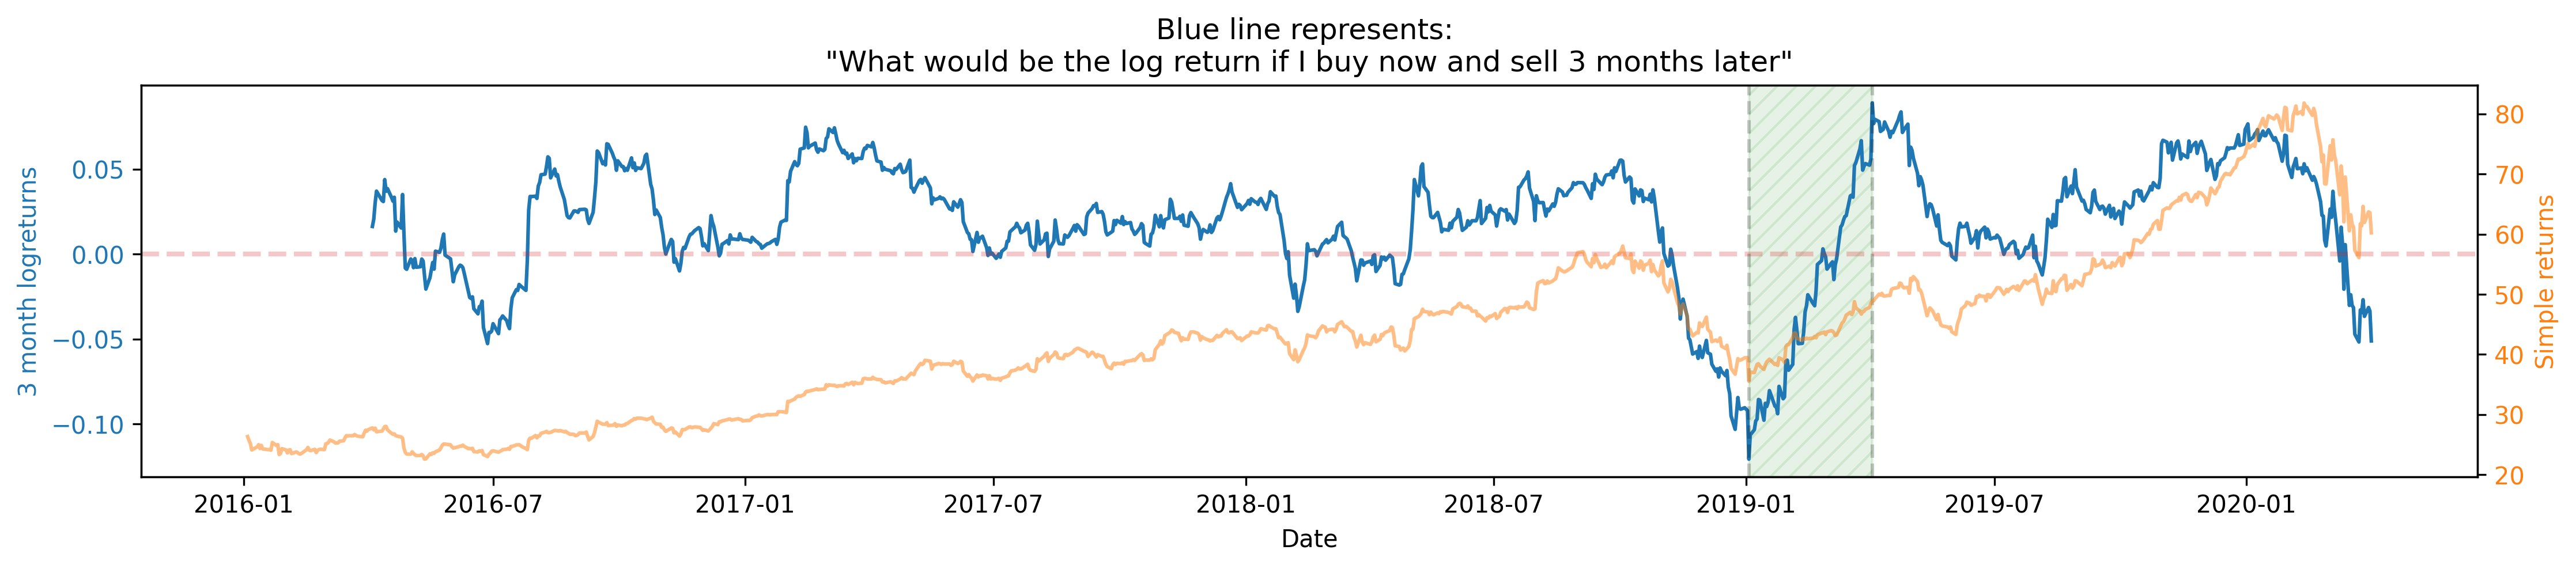

In [55]:
ReturnsPlot(aapl_stock_data['log_return_3m'], 
            'Blue line represents: \n"What would be the log return if I buy now and sell 3 months later"',
            y_labels=['3 month logreturns', 'Simple returns'],
            second_data=aapl_stock_data['Close'],
            fig_kwargs={'figsize': (15, 3), 'dpi': 300},
            grid=False,
            max_return=True,)

#### **Next step: create the sequence for use in LSTM**
We need a tensor with 3 dimensions; \
**One** for all samples (sequences leading up to our prediction) which is each day of the time period. \
**One** for the number of time steps we use to make the one prediction. Going with 3 months, we have approximately 62 datapoints, since weekends and holidays arent trading days. (~21 working days a month). \
**The** last dimension is the number of features(explanatory variables) that we use in the model.

In [103]:
def create_sequences(data, sequence_len=62, horizon=62):
    """
    outputs feature sequences of length sequence_len
    for each day in the data, starting from the sequence_len'th day (62nd day e.g.)
    
    target is the return at the horizon'th day (62 days later e.g.)
    """
    
    features = []
    target = []

    for day in range(len(data) - sequence_len - horizon):
        features.append(data.iloc[day:day+sequence_len])
        target.append(data.iloc[day+sequence_len+horizon])

    # return tensors for features and target, based on the lists
    return torch.from_numpy(np.array(features)), torch.from_numpy(np.array(target))
    

In [104]:
X, y = create_sequences(aapl_stock_data[['log_return_3m']], 62, 62) # use 3 month log returns to predict log returns in 3 month

In [110]:
X.shape, y.shape

(torch.Size([945, 62, 1]), torch.Size([945, 1]))

#### Example of shifting data

In [72]:
shifting_data = pd.DataFrame({'x1': [3,3,3,3,3,3,3,3,3,3],
                              '2dayReturn': [0,0,5,5,5,5,5,5,5,5],
                              })
shifting_data

,x1,2dayReturn
0,3,0
1,3,0
2,3,5
3,3,5
4,3,5
5,3,5
6,3,5
7,3,5
8,3,5
9,3,5


In [73]:
shifting_data['target'] = shifting_data['2dayReturn'].shift(-2)

In [76]:
# sum of nan values
shifting_data

,x1,2dayReturn,target
0,3,0,5.0
1,3,0,5.0
2,3,5,5.0
3,3,5,5.0
4,3,5,5.0
5,3,5,5.0
6,3,5,5.0
7,3,5,5.0
8,3,5,NaN
9,3,5,NaN


### **Now we do it for all the stocks**

In [9]:
# we want the 3 month return for each ticker, and here we concat them together so they can create the new column next cell
returns_series = pd.concat([ThreeMonthReturn(raw_stock_data[raw_stock_data['Ticker'] == ticker]['Close'].copy()) for ticker in stock_tickers])

In [ ]:
for ticker in stock_tickers:
    raw_stock_data[raw_stock_data['Ticker'] == ticker]['Close'].copy()

In [10]:
raw_stock_data['3month_return'] = returns_series

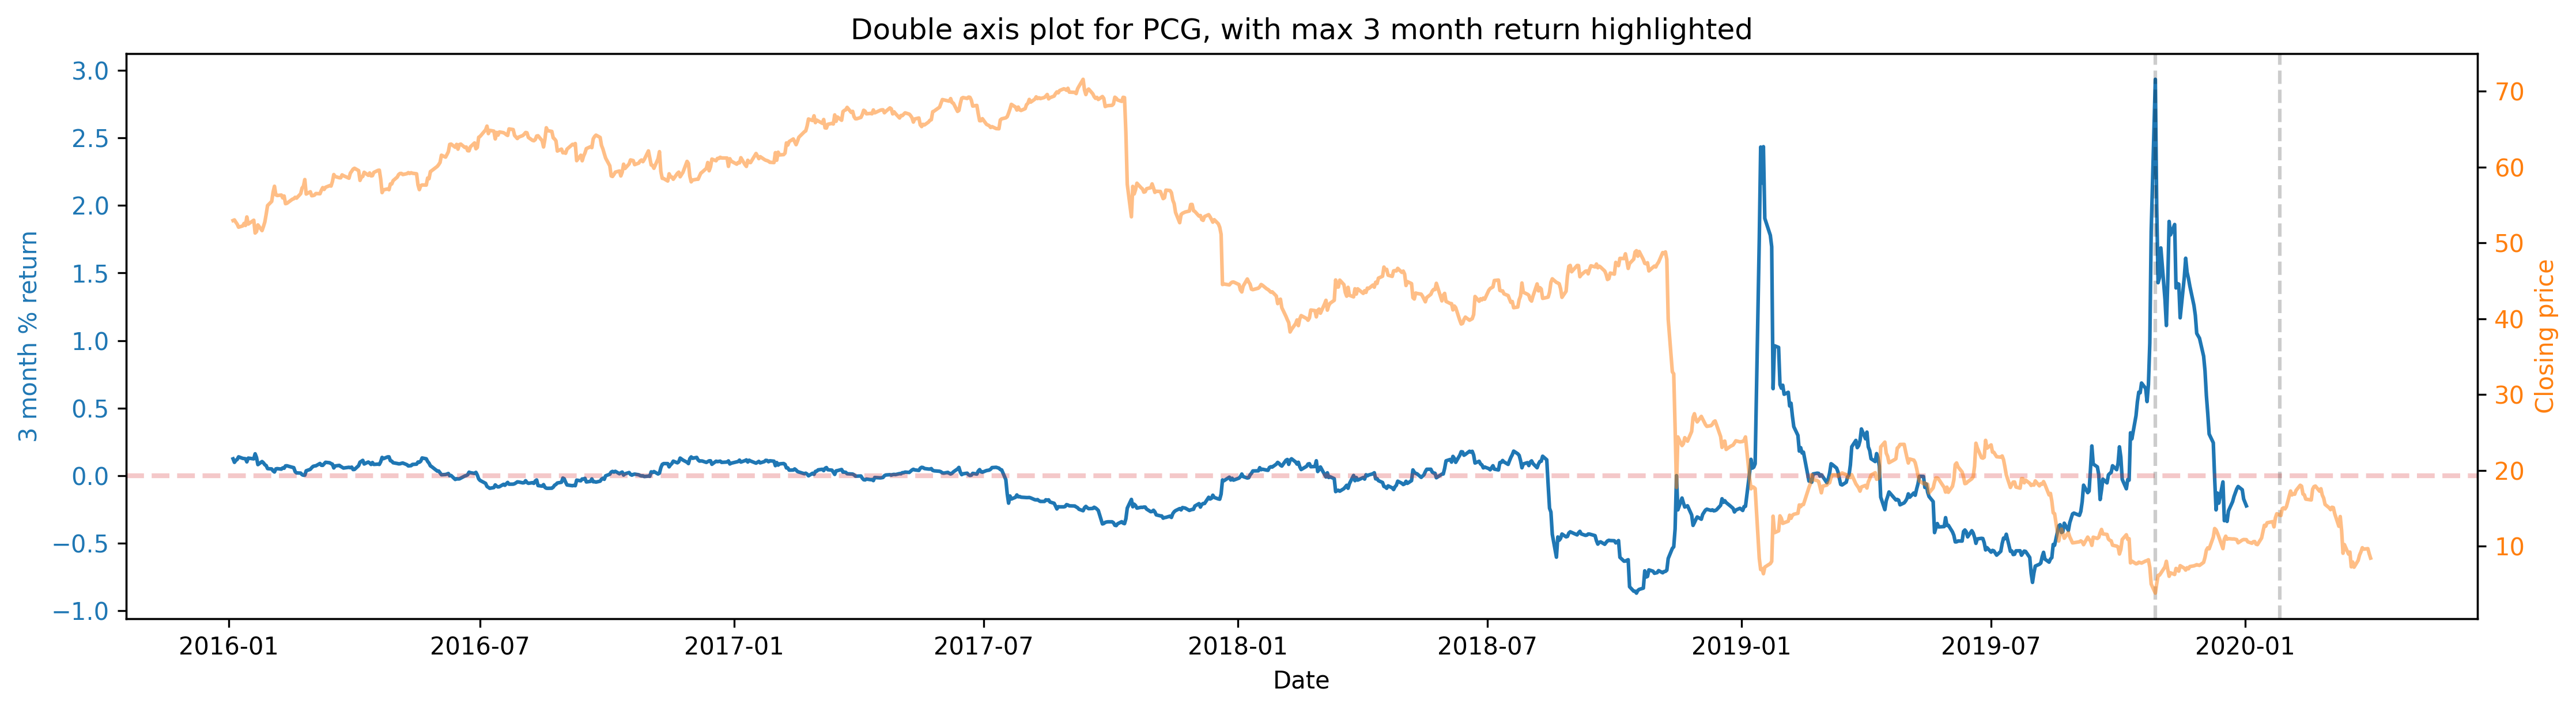

In [11]:
ReturnsPlot(raw_stock_data[raw_stock_data['Ticker'] == 'PCG'],
            'Double axis plot for PCG, with max 3 month return highlighted',
            double_axis=True,
            fig_kwargs={'figsize': (15, 4), 'dpi': 300},
            grid=False,
            max_return=True,)

### **Save the new dataset for usage in modelling with LSTM**

In [12]:
# save
raw_stock_data.to_csv('data/SP500_stock_prices_with_3month_return.csv')